In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
n_neurons = 1024
n_steps = 10000
n_driven_current = 16
n_recorded_neuron = 32
time_spacing = 0.02

In [60]:
"""generate weights"""
np.random.seed(123)
weight_sigma = 30.
weights = np.random.normal(0, weight_sigma, (n_neurons, n_neurons))/np.sqrt(n_neurons)
np.fill_diagonal(weights, 0.)
weights.tofile('weights_1024.bin')

In [61]:
"""generate inital neuron state"""
vs = np.ones((n_neurons, 1))*(-50.0)
vs = np.arange(n_neurons).reshape((n_neurons, 1))
gates = np.random.uniform(0, 1, (n_neurons, 3))
states = np.concatenate((vs, gates), axis=-1)
states.tofile("initial_states_1024.bin")

In [62]:
"""generate driving currents"""
def random_harmonics(seed, n_harmonics, period_range, coeff_range, amplitude):
    np.random.seed(seed)
    periods = np.random.uniform(period_range[0], period_range[1], n_harmonics)
    coeffs = np.random.uniform(coeff_range[0], coeff_range[1], n_harmonics)
    coeffs = amplitude/np.sum(np.abs(coeffs))*coeffs
    phases = np.random.uniform(0, 2*np.pi, n_harmonics)
    def fun(t):
        tmps = coeffs*np.sin(2*np.pi*t/periods + phases)
        return np.sum(tmps)
        # return 0.
    return np.vectorize(fun)

driving_currents = np.zeros((n_driven_current, n_steps))
for i in range(n_driven_current):
    driving_currents[i] = random_harmonics(seed=i+n_neurons, n_harmonics=10, period_range=(5, 50), coeff_range=(0, 1), amplitude=30)(np.arange(0, n_steps)*time_spacing)
# driving_currents = np.ones((2, n_steps))*100 # for simplicity, just use a constant current. 
driving_currents.tofile("driving_currents_1024_16.bin")

In [80]:
"""get recorded data"""
voltage_record_openmp = np.fromfile("voltage_record_openmp.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))
voltage_record_mpi = np.fromfile("voltage_record_mpi.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))
voltage_record_mpi_openmp = np.fromfile("voltage_record_mpi_openmp.bin", dtype=np.float64).reshape((n_recorded_neuron, n_steps))

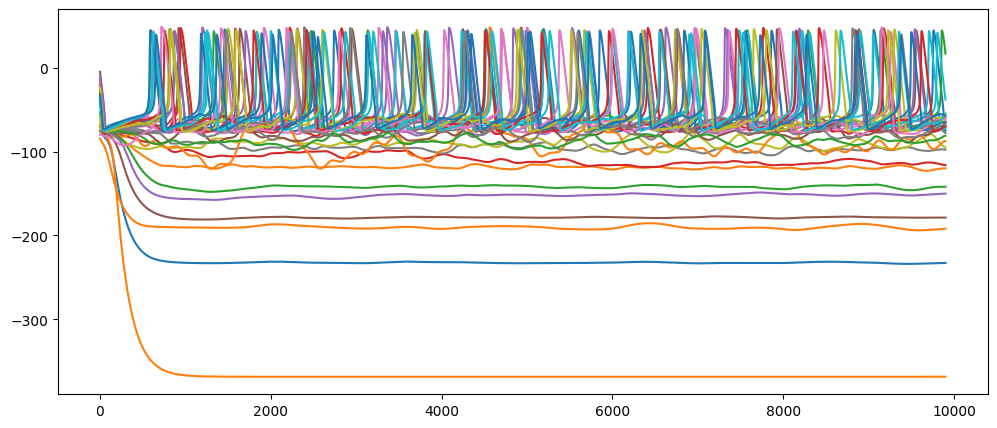

In [81]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
# for i in range(n_recorded_neuron):
for i in range(32):
    axes.plot(voltage_record_openmp[i, 100:])

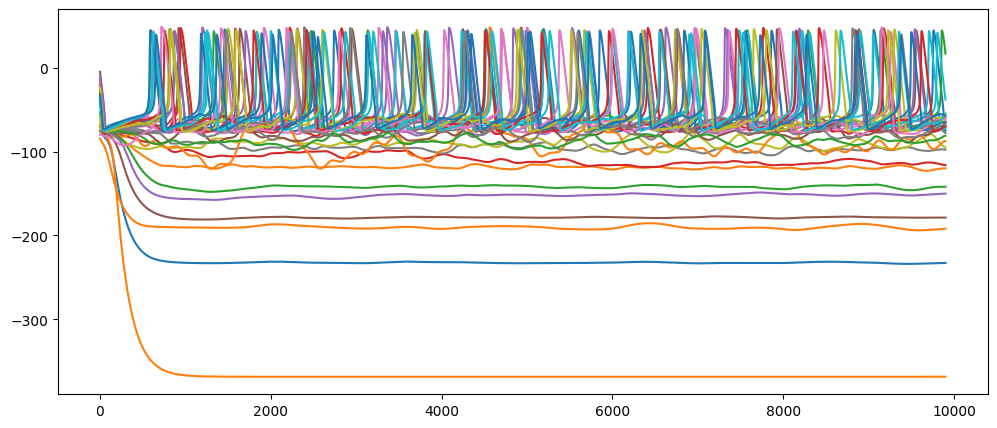

In [82]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
# for i in range(n_recorded_neuron):
for i in range(32):
    axes.plot(voltage_record_mpi[i, 100:])

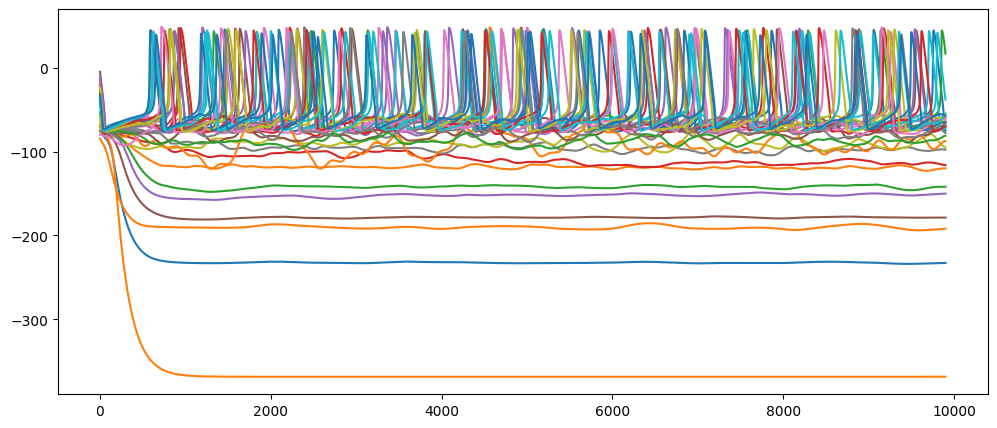

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
# for i in range(n_recorded_neuron):
for i in range(32):
    axes.plot(voltage_record_mpi_openmp[i, 100:])

In [186]:
np.sort(np.random.choice(n_neurons, n_driven_current, replace=False))

array([ 28,  77, 152, 351, 387, 405, 497, 516, 560, 589, 638, 669, 728,
       763, 838, 992])

In [187]:
np.sort(np.random.choice(n_neurons, n_recorded_neuron, replace=False))

array([  34,  171,  193,  214,  267,  270,  271,  321,  347,  358,  372,
        387,  388,  420,  471,  504,  505,  515,  577,  636,  718,  735,
        753,  761,  765,  776,  834,  838,  924,  974,  977, 1013])